In [351]:
import sys, os, random, re, glob, copy
import pprint as pp
#from functools import reduce

In [352]:
#!pip3 install 'pyLDAvis>3,<3.4'

In [353]:
#!pip3 install -U plotly
#!pip3 install -U seaborn
#!pip3 install -U adjustText

In [354]:
## NBConvert のために
#!pip install -U nbconvert
#!pip install -U pyppeteer

Settings for data

In [355]:
## 一般設定
verbose   = False
save_data = False

## 分野の設定
domains = { 'medical'    : True,
            'mce'        : False,
            'cooking'    : True,
            'economic'   : True,
            'juridical'  : True,
            'publishing' : True
            }

target_vars = ['word']
target_vars.extend(domains.keys())
print(f"target_vars: {target_vars}")

## 分野の選択
selected_domains = { k:v for k,v in domains.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")

## domain count balancing
if len(selected_domains) > 1:
    balanced = True
else:
    balanced = False
print(f"domain balancing: {balanced}")

target_vars: ['word', 'medical', 'mce', 'cooking', 'economic', 'juridical', 'publishing']
selected domains: ['medical', 'cooking', 'economic', 'juridical', 'publishing']
domain balancing: True


In [356]:
## colormap
colormap =  [ 'deeppink', 'pink',  'orange', 'green', 'paleturquoise', 'wheat', 'gray' ]
for d, c in zip(domains, colormap):
    print(f"分野 {d}".ljust(16) + ": " + f"色 {c}")

分野 medical      : 色 deeppink
分野 mce          : 色 pink
分野 cooking      : 色 orange
分野 economic     : 色 green
分野 juridical    : 色 paleturquoise
分野 publishing   : 色 wheat


Settings for LDA

In [357]:
## LDA の基本設定

## topic 数の指定
n_topics = 10 # 変更可能: 値が大きい方が分類は詳細だが，大分類は収束しない

## doc, term の設定
doc_type    = 'word'
term_size   = 'character'
term_types  = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram' ]  
term_type   = term_types[0]
print(f"used term: {term_type}")

## n-gram を包括 (n-gram が (n-1)を真に含む) 型にするかどうか
## 包括型にしないと，n が大きくなった時にエンコードされない事例が生じる
ngram_is_inclusive = True

## doc の最大長
discard_too_long = True
max_doc_length = 12 # effective if discard_too_long

## skippy n-gram が結びつく最長の gram数: bigram と trigram で共有
max_distance_val = round(max_doc_length * 0.75)
print(f"skippy n-gram max_distance: {max_distance_val}")

## skippy n-gram の記号
gap_mark = "…"

## Raw term の濾過
remove_highly_frequent_unigrams = False
cutoff_rate = 0.005 # discard the most frequest <rate> of the terms 

## DTM のterm 濾過の設定
minfreq = 2 # 最低頻度
abuse_threshold = 0.01 # 値が小さい方が濾過力が大きい．0.1 は十分に大きい．

used term: 1gram
skippy n-gram max_distance: 9


Settings for tSNE

In [358]:
### tSNE の設定

## topic の tSNE 用の設定
top_perplexity_reduct_rate = 0.5
print(f"top_perplexity_rate: {top_perplexity_reduct_rate}")

## doc の tSNE 用の設定
doc_perplexity_reduct_rate1 = 0.33 # topic数に依存する場合
doc_perplexity_reduct_rate2 = 0.1 # doc数に依存する場合

## doc_perplexity を n_topics に基づいて決めるか事例数に基づいて決めるかの選択
doc_perplexity_depends_on_n_topics = False
if doc_perplexity_depends_on_n_topics:
    doc_perplexity_reduc_rate = doc_perplexity_reduct_rate1
else:
    doc_perplexity_reduct_rate = doc_perplexity_reduct_rate2
print(f"doc_perplexity_reduct_rate: {doc_perplexity_reduct_rate}")

top_perplexity_rate: 0.5
doc_perplexity_reduct_rate: 0.1


In [359]:
## load data to process
from pathlib import Path
import pprint as pp

wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
print(f"The following {len(dirs)} directories are potential targets:")
pp.pprint(sorted(dirs))

The following 6 directories are potential targets:
[PosixPath('.git'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('__pycache__'),
 PosixPath('results'),
 PosixPath('saves'),
 PosixPath('terms-source')]


In [360]:
## list up files in target directory 

targetdir = "terms-source" # can be changed
files = sorted(list(wd.glob(f"{targetdir}/terms*.xlsx")))
#
print(f"\n{targetdir} contains {len(files)} files to process")
pp.pprint(files)


terms-source contains 7 files to process
[PosixPath('terms-source/terms-cooking-v1a.xlsx'),
 PosixPath('terms-source/terms-economic-v1b.xlsx'),
 PosixPath('terms-source/terms-juridical-v1a2.xlsx'),
 PosixPath('terms-source/terms-juridical-v1b2.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-v1b.xlsx'),
 PosixPath('terms-source/terms-publishing-v1b.xlsx')]


In [361]:
## 本来のファイルの処理
files_core = [ file for file in files if not "juridical-v1b2" in str(file) ]
files_core

[PosixPath('terms-source/terms-cooking-v1a.xlsx'),
 PosixPath('terms-source/terms-economic-v1b.xlsx'),
 PosixPath('terms-source/terms-juridical-v1a2.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-v1b.xlsx'),
 PosixPath('terms-source/terms-publishing-v1b.xlsx')]

In [362]:
## 必要に応じて次を実行
#!pip install -U openpyxl

In [363]:
import numpy as np
import pandas as pd

raw_dfs = [ ]
for file in files_core:
    ## 出版用語のsampled = 1 の場合のみ選別
    if "publishing" in str(file):
        d = pd.read_excel(file) # requires openpyxl to be installed
        d = d[d['local.id'] != None]
        d = d[d['sampled'] == 1]
        raw_dfs.append(d)
    else:
        raw_dfs.append(pd.read_excel(file)) # requires openpyxl to be installed
raw_dfs

[      local.id       word  medical  mce  economic  juridical  publishing  \
 0       2774.0  中華風コーンスープ      0.0  0.0       0.0        0.0         0.0   
 1       4614.0       酒びたし      0.0  0.0       0.0        0.0         0.0   
 2       1830.0       ハチの身      0.0  0.0       0.0        0.0         0.0   
 3        544.0      かにしゃぶ      0.0  0.0       0.0        0.0         0.0   
 4       3982.0     煮込みカツ丼      0.0  0.0       0.0        0.0         0.0   
 ...        ...        ...      ...  ...       ...        ...         ...   
 4989    2173.0         ヘラ      0.0  0.0       0.0        0.0         0.0   
 4990    3522.0        日向夏      0.0  0.0       0.0        0.0         0.0   
 4991       NaN        NaN      NaN  NaN       NaN        NaN         NaN   
 4992       NaN        NaN      NaN  NaN       NaN        NaN         NaN   
 4993       NaN        NaN      NaN  NaN       NaN        NaN         NaN   
 
       cooking  valid     rid  subsampled  note  
 0         1.0    1.0   

In [364]:
## DataFrame 構築
check = False
dfs = [ ]
for dfx in raw_dfs:
    d = dfx[target_vars]
    if check:
        print(d)
    dfs.append(d)
#
df0 = pd.concat(dfs)
df0

,word,medical,mce,cooking,economic,juridical,publishing
0,中華風コーンスープ,0.0,0.0,1.0,0.0,0.0,0.0
1,酒びたし,0.0,0.0,1.0,0.0,0.0,0.0
2,ハチの身,0.0,0.0,1.0,0.0,0.0,0.0
3,かにしゃぶ,0.0,0.0,1.0,0.0,0.0,0.0
4,煮込みカツ丼,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1528,仮扉,0.0,0.0,0.0,0.0,0.0,1.0
1529,無線綴じ,0.0,0.0,0.0,0.0,0.0,1.0
1530,端物,0.0,0.0,0.0,0.0,0.0,1.0
1531,裁ち板,0.0,0.0,0.0,0.0,0.0,1.0


In [365]:
## 追加ファイルの処理
added_file = [ file for file in files if not file in files_core ][0]
raw_juridic2 = pd.read_excel(added_file)

## juridical の sampled=1 のみを選別
raw_juridic2 = raw_juridic2[ raw_juridic2['sampled'] == 1 ]
raw_juridic2 = raw_juridic2[ target_vars ]

##
add_juridic2 = True
if add_juridic2:
    df0 = pd.concat([df0, raw_juridic2])
#
df0

,word,medical,mce,cooking,economic,juridical,publishing
0,中華風コーンスープ,0.0,0.0,1.0,0.0,0.0,0.0
1,酒びたし,0.0,0.0,1.0,0.0,0.0,0.0
2,ハチの身,0.0,0.0,1.0,0.0,0.0,0.0
3,かにしゃぶ,0.0,0.0,1.0,0.0,0.0,0.0
4,煮込みカツ丼,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
889,訴訟指揮,0.0,0.0,0.0,0.0,1.0,0.0
890,上告審,0.0,0.0,0.0,0.0,1.0,0.0
893,制限行為能力者,0.0,0.0,0.0,0.0,1.0,0.0
894,被控訴人,0.0,0.0,0.0,0.0,1.0,0.0


In [366]:
## 長過ぎる語を除外したデータに置換え

#max_doc_length = 12 # 定義を先頭に移動
if discard_too_long:
    df0 = df0[ [ True if len(str(x)) < max_doc_length else False for x in df0[doc_type] ] ]
#
len(df0)

11789

In [367]:
## 色分けの為の domain_id を定義

check = False
domains = [ ]
for i, row in df0.iterrows():
    if check:
        print(f"{row['medical']}, {row['mce']}, {row['cooking']}, {row['economic']}, {row['juridical']}, {row['publishing']}" )
    if row['medical'] == 1:
        domains.append(0)
    elif row['mce'] == 1:
        domains.append(1)
    elif row['cooking'] == 1:
        domains.append(2)
    elif row['economic'] == 1:
        domains.append(3)
    elif row['juridical'] == 1:
        domains.append(4)
    elif row['publishing'] == 1:
        domains.append(5)
    else:
        domains.append(6)
#
df0['domain_id'] = domains

## domain の事例数の確認
df0['domain_id'].value_counts().sort_index()

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_9182/3636843653.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



domain_id
0    3423
1     812
2    4886
3     497
4     645
5    1514
6      12
Name: count, dtype: int64

In [368]:
## 分野の事例数の確認

S = [ ]
for domain in selected_domains.keys():
    print(f"domain: {domain}")
    S.append(df0[df0[domain] == 1])

df0 = pd.concat(S, axis = 0)
df0

domain: medical
domain: cooking
domain: economic
domain: juridical
domain: publishing


,word,medical,mce,cooking,economic,juridical,publishing,domain_id
0,大腿骨,1.0,0.0,0.0,0.0,0.0,0.0,0
1,聴神経腫瘍,1.0,0.0,0.0,0.0,0.0,0.0,0
2,多発性昆虫咬創,1.0,0.0,0.0,0.0,0.0,0.0,0
3,脊髄挫傷,1.0,0.0,0.0,0.0,0.0,0.0,0
4,自家移植,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
1528,仮扉,0.0,0.0,0.0,0.0,0.0,1.0,5
1529,無線綴じ,0.0,0.0,0.0,0.0,0.0,1.0,5
1530,端物,0.0,0.0,0.0,0.0,0.0,1.0,5
1531,裁ち板,0.0,0.0,0.0,0.0,0.0,1.0,5


In [369]:
## 混合のための割合を調整

if balanced:
    sample_size = 500
    # Medical
    if 'medical' in selected_domains.keys():
        med_sampled = df0[ df0['medical'] == 1 ].sample(sample_size, replace = True)
    else:
        med_sampled = None
    # Cooking
    if 'cooking' in selected_domains.keys():
        try:
            cook_sampled = df0[ df0['cooking'] == 1 ].sample(sample_size, replace = True)
        except ValueError:
            cook_sampled = df0[ df0['cooking'] == 1 ]
    else:
        cook_sampled = None
    # Juridical
    if 'juridical' in selected_domains.keys():
        jurid_sampled = df0[ df0['juridical'] == 1 ].sample(sample_size, replace = True)
    else:
        jurid_sampled = None
    # Publishing
    if 'publishing' in selected_domains.keys():
        pub_sampled = df0[ df0['publishing'] == 1 ].sample(sample_size, replace = True)
    else:
        pub_sampled = None
    ## integration
    df0 = pd.concat([med_sampled, cook_sampled, jurid_sampled, pub_sampled,
                 df0[df0['mce'] == 1],
                 df0[df0['economic'] == 1]])

## domain の事例数の確認
df0['domain_id'].value_counts(sort = True)

## 0: 医療用語
## 1: 医療縮約表現
## 2: 調理用語
## 3: 経済用語
## 4: 法律用語
## 5: 出版用語
## 6: その他

domain_id
0    500
2    500
4    500
5    500
3    497
Name: count, dtype: int64

In [370]:
## 順序をランダマイズし df0 を df として再定義

import sklearn.utils
df = sklearn.utils.shuffle(df0)

In [371]:
## 設定の確認

doc_type
df['word']

172         混合農業
195      イントラネット
735         交付送達
20          通商条約
599           貸付
          ...   
4845    ぼろじのクッキー
31          反対尋問
452       審査請求命令
2673       除去食療法
468        貨幣・信用
Name: word, Length: 2497, dtype: object

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_9182/3406274446.py:13: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



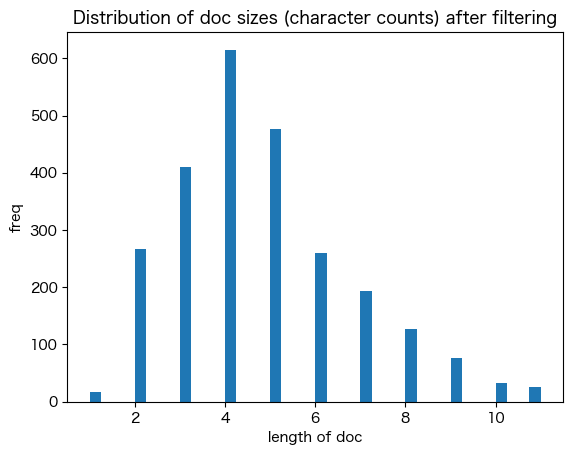

In [372]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

d = [ len(x) for x in df[doc_type] ]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(d, bins = 40)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of doc sizes (character counts) after filtering")
fig.show()

DTM 構築

In [373]:
## 共有される名称の定義

docs = df[doc_type]
docs

172         混合農業
195      イントラネット
735         交付送達
20          通商条約
599           貸付
          ...   
4845    ぼろじのクッキー
31          反対尋問
452       審査請求命令
2673       除去食療法
468        貨幣・信用
Name: word, Length: 2497, dtype: object

In [374]:
## 1gram 生成

check = False
unigrams = [ ]
for x in docs:
    if check: print(x)
    u = list(x)
    if len(u) > 0:
        unigrams.append(u)
#
random.sample(unigrams, 3)

[['被', '申', '立', '担', '保', '権', '者'], ['ソ', 'ー', 'キ', 'そ', 'ば'], ['調', '停']]

In [375]:
## 名称の設定
df['1gram'] = unigrams
df

,word,medical,mce,cooking,economic,juridical,publishing,domain_id,1gram
172,混合農業,0.0,0.0,0.0,1.0,0.0,0.0,3,"[混, 合, 農, 業]"
195,イントラネット,0.0,0.0,0.0,1.0,0.0,0.0,3,"[イ, ン, ト, ラ, ネ, ッ, ト]"
735,交付送達,0.0,0.0,0.0,0.0,1.0,0.0,4,"[交, 付, 送, 達]"
20,通商条約,0.0,0.0,0.0,1.0,0.0,0.0,3,"[通, 商, 条, 約]"
599,貸付,0.0,0.0,0.0,0.0,1.0,0.0,4,"[貸, 付]"
...,...,...,...,...,...,...,...,...,...
4845,ぼろじのクッキー,0.0,0.0,1.0,0.0,0.0,0.0,2,"[ぼ, ろ, じ, の, ク, ッ, キ, ー]"
31,反対尋問,0.0,0.0,0.0,0.0,1.0,0.0,4,"[反, 対, 尋, 問]"
452,審査請求命令,0.0,0.0,0.0,0.0,1.0,0.0,4,"[審, 査, 請, 求, 命, 令]"
2673,除去食療法,1.0,0.0,0.0,0.0,0.0,0.0,0,"[除, 去, 食, 療, 法]"


In [376]:
## 1gram の頻度を取得

import collections
unigrams_all = [ ]
[ unigrams_all.extend(L) for L in df['1gram'] ]

unigram_freqs = collections.Counter(unigrams_all)
unigram_freqs.most_common(20)

[('ー', 243),
 ('ン', 176),
 ('の', 159),
 ('性', 151),
 ('ス', 91),
 ('り', 89),
 ('ト', 85),
 ('ル', 76),
 ('し', 75),
 ('ラ', 73),
 ('ッ', 72),
 ('ク', 72),
 ('ん', 69),
 ('イ', 68),
 ('き', 68),
 ('ア', 61),
 ('炎', 60),
 ('機', 59),
 ('紙', 59),
 ('カ', 57)]

In [377]:
## 高頻度 1gram フィルターの産物を確認

highly_frequents = sorted(unigram_freqs, reverse = True)[:round(cutoff_rate * len(df['1gram']))]
highly_frequents

['／', '％', '龍', '齢', '鼻', '鼓', '黒', '黄', '麻', '麺', '麩', '麦']

In [378]:
## 高頻度 1-gram の除外

if remove_highly_frequent_unigrams:
    df['1gram'].apply(lambda x:
                     [ u for u in df['1gram'] if not u in highly_frequents ] )

In [379]:
## bigram 生成

check = False
n = 2
bigrams = [ ]
for doc in docs:
    if check: print(doc)
    size = len(doc)
    if size < n:
         bigrams.append([doc])
    else:
        L = [ ]
        for i in range(size - n + 1):
            x = doc[ i:i+n ]
            if check: print(x)
            if len(x) == n:
                L.append(x)
        if len(L) > 0:
            bigrams.append(L)

## 包括的 2gramの生成
if ngram_is_inclusive:
    for i, b in enumerate(bigrams):
        b.extend(unigrams[i])
#
random.sample(bigrams, 3)

[['NI', 'IE', 'ES', 'N', 'I', 'E', 'S'],
 ['細川', '川紙', '細', '川', '紙'],
 ['康煕', '煕字', '字典', '康', '煕', '字', '典']]

In [380]:
## 変数の追加

df['2gram'] = bigrams
if verbose:
    df

In [381]:
## trigram 生成

check = False
n = 3
trigrams = [ ]
for doc in docs:
    if check: print(f"doc: {doc}")
    size = len(doc)
    if size < n:
        trigrams.append([doc]) 
    else:
        L = [ ]
        for i in range(size - n + 1):
            x = doc[ i:i+n ]
            if check: print(f"x: {x}")
            if len(x) == n:
                L.append(x)
        if check: print(f"L: {L}")
        #if len(L) > 0:
        trigrams.append(L)

## 包括的 3gramの生成
if ngram_is_inclusive:
    for i, t in enumerate(trigrams):
        t.extend(bigrams[i])
#
random.sample(trigrams, 3)

[['弁明', '弁明', '弁', '明'],
 ['突き揃',
  'き揃え',
  '揃え装',
  'え装置',
  '突き',
  'き揃',
  '揃え',
  'え装',
  '装置',
  '突',
  'き',
  '揃',
  'え',
  '装',
  '置'],
 ['前頭部', '頭部挫', '部挫創', '前頭', '頭部', '部挫', '挫創', '前', '頭', '部', '挫', '創']]

In [382]:
## 変数の追加

df['3gram'] = trigrams
if verbose:
    df

In [383]:
## skippy ngram の生成

#import sys
#sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

## skippy 2grams の生成
skippy2grams = [ ngrams_skippy.generate_skippy_bigrams(x,
                                                       missing_mark = gap_mark,
                                                       max_distance = max_distance_val,
                                                       minimize = False,
                                                       check = False)
                for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy2grams):
        b2.extend(unigrams[i])
#
random.sample(skippy2grams, 3)

[['PB', 'P', 'B'],
 ['経済', '経', '済'],
 ['アジ',
  'ア…ア',
  'ア…的',
  'ア…生',
  'ア…産',
  'ア…様',
  'ア…式',
  'ジア',
  'ジ…的',
  'ジ…生',
  'ジ…産',
  'ジ…様',
  'ジ…式',
  'ア的',
  'ア…生',
  'ア…産',
  'ア…様',
  'ア…式',
  '的生',
  '的…産',
  '的…様',
  '的…式',
  '生産',
  '生…様',
  '生…式',
  '産様',
  '産…式',
  '様式',
  'ア',
  'ジ',
  'ア',
  '的',
  '生',
  '産',
  '様',
  '式']]

In [384]:
## 変数の追加
df['skippy2gram'] = skippy2grams
if verbose:
    df

In [385]:
## skippy 3grams
skippy3grams = [ ngrams_skippy.generate_skippy_trigrams(x,
                                                        missing_mark = gap_mark,
                                                        max_distance = max_distance_val,
                                                        minimize = False,
                                                        check = False)
                for x in df[doc_type] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy3grams):
        t2.extend(skippy2grams[i])
#
random.sample(skippy3grams, 2)

[['足褥瘡', '足褥', '足…瘡', '褥瘡', '足', '褥', '瘡'],
 ['エー・',
  'エー…ピ',
  'エー…ー',
  'エ…・ピ',
  'エ…・…ー',
  'エ…ピー',
  'ー・ピ',
  'ー・…ー',
  'ー…ピー',
  '・ピー',
  'エー',
  'エ…・',
  'エ…ピ',
  'エ…ー',
  'ー・',
  'ー…ピ',
  'ー…ー',
  '・ピ',
  '・…ー',
  'ピー',
  'エ',
  'ー',
  '・',
  'ピ',
  'ー']]

In [386]:
## 変数の追加
df['skippy3gram'] = skippy3grams
if verbose:
    df

In [387]:
## 使ったデータの保存

if save_data:
    import datetime as dt
    ct = dt.datetime.now()
    ## Pandas で .csv として
    output_fn1 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".csv"
    print(f"saving data to {output_fn1}")
    import pandas as pd
    df.to_csv(output_fn1)
    ## pickle.dump(..)で
    output_fn2 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".p"
    import pickle
    print(f"saving data to {output_fn2}")
    with open(output_fn2, "wb") as f:
        pickle.dump(df, f)

In [388]:
## 解析対象の確認
bots = df[term_type]
bots

172                 [混, 合, 農, 業]
195        [イ, ン, ト, ラ, ネ, ッ, ト]
735                 [交, 付, 送, 達]
20                  [通, 商, 条, 約]
599                       [貸, 付]
                  ...           
4845    [ぼ, ろ, じ, の, ク, ッ, キ, ー]
31                  [反, 対, 尋, 問]
452           [審, 査, 請, 求, 命, 令]
2673             [除, 去, 食, 療, 法]
468              [貨, 幣, ・, 信, 用]
Name: 1gram, Length: 2497, dtype: object

In [389]:
## stopwords を除外
discarded = [ '腫瘍', '性', '炎', '血', '腫', '瘍', 'の' ]

remove_stopwords = False
if remove_stopwords:
    bows = [ [ x for x in bot if x not in discarded ] for bot in bots ]
#
if verbose:
    random.sample(list(bots), 3)

LDA を実行

In [390]:
## LDA 構築の基になる dictionary = document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<1465 unique tokens: ['合', '業', '混', '農', 'イ']...>


In [391]:
## 構造の確認

for k in random.sample(diction.keys(), 10):
    print(f"index: {k} ; term: {diction[k]}")

index: 1087 ; term: 依
index: 115 ; term: ズ
index: 112 ; term: 内
index: 309 ; term: 援
index: 1307 ; term: 冠
index: 9 ; term: ン
index: 316 ; term: と
index: 105 ; term: ソ
index: 690 ; term: 囲
index: 616 ; term: 圧


In [392]:
## diction の検査

import pandas as pd
from operator import attrgetter
from collections import namedtuple

freq_record = namedtuple('record', ['term', 'freq'])
term_freqs = [ freq_record(*x) for x in diction.most_common() ] ## most_common allows access to frequencies
terms_freqs = sorted(term_freqs, key=attrgetter('freq'), reverse=True)

## term の頻度順位で上位30件
term_freqs[:20]

[record(term='ー', freq=243),
 record(term='ン', freq=176),
 record(term='の', freq=159),
 record(term='性', freq=151),
 record(term='ス', freq=91),
 record(term='り', freq=89),
 record(term='ト', freq=85),
 record(term='ル', freq=76),
 record(term='し', freq=75),
 record(term='ラ', freq=73),
 record(term='ッ', freq=72),
 record(term='ク', freq=72),
 record(term='ん', freq=69),
 record(term='イ', freq=68),
 record(term='き', freq=68),
 record(term='ア', freq=61),
 record(term='炎', freq=60),
 record(term='機', freq=59),
 record(term='紙', freq=59),
 record(term='カ', freq=57)]

In [393]:
## 頻度1 のterm の個数
hapax = [ record for record in term_freqs if record.freq == 1]
len(hapax)

391

In [394]:
## 頻度1 の term のサンプル10件
random.sample(hapax, 10)

[record(term='矯', freq=1),
 record(term='腋', freq=1),
 record(term='次', freq=1),
 record(term='鮭', freq=1),
 record(term='奈', freq=1),
 record(term='衡', freq=1),
 record(term='V', freq=1),
 record(term='藩', freq=1),
 record(term='艦', freq=1),
 record(term='鮑', freq=1)]

In [395]:
## diction の濾過

import copy
diction_copy = copy.deepcopy(diction) # 予備の生成

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq, no_above = abuse_threshold)

## check
print(diction_copy)

Dictionary<974 unique tokens: ['混', '農', 'ネ', '交', '付']...>


In [396]:
## データを選択
diction = diction_copy # 名前を元に戻す

## gensim の用 corpusの構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
print(f"Number of documents: {len(corpus)}")

Number of documents: 2497


In [397]:
## check
if verbose:
    print(random.sample(corpus, 5))

In [398]:
## LDA モデルの構築

from gensim.models import LdaModel
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(lda)

LdaModel<num_terms=974, num_topics=10, decay=0.5, chunksize=2000>


In [399]:
## 結果の検査

sample_n = 3
for doc in random.sample(list(df[doc_type]), sample_n):
    print(doc)
    p_dist = lda.get_document_topics(diction.doc2bow([f"{doc}"]), minimum_probability = 0)
    print(p_dist)
    print(f"sums up to: {sum(p_dist[1])} over {len(p_dist)} topics")

公務労働
[(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
sums up to: 1.1000000014901161 over 10 topics
フィランソロピー
[(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
sums up to: 1.1000000014901161 over 10 topics
耳介擦過創
[(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
sums up to: 1.1000000014901161 over 10 topics


In [400]:
%%capture --no-display

## lda のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 20 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10
0,脈,脱,疹,労,ィ,場,骨,裁,自,腸
1,有,核,帯,働,政,丸,見,背,登,サ
2,連,臼,疱,損,妊,社,切,ュ,が,理
3,書,関,蓋,下,さ,異,中,長,録,え
4,指,節,体,天,デ,餅,保,審,は,筋
5,と,ば,督,付,ョ,同,豆,員,も,縮
6,支,そ,団,物,娠,ダ,ャ,問,げ,務
7,代,せ,時,肺,お,外,毛,ゼ,感,わ
8,固,間,頭,飯,A,ェ,譲,訴,標,体
9,移,年,術,転,策,義,渡,成,財,び


LDAvis の実行

In [401]:
%%capture --no-display

## pyLDAvis を使った結果 D_lda の可視化: 階層クラスタリングより詳しい

import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_MMDS = True
use_tsne = False
if use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds', n_jobs = 1, sort_topics = False)
elif use_tsne:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)

## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [402]:
## LDA がD に対して生成した topics の弁別性を確認

## 得られたtopics を確認
topic_dist = lda.get_topics()

## 型は numpy.ndarry
type(topic_dist)

numpy.ndarray

In [403]:
if check:
    random.sample(list(topic_dist), 5)

In [404]:
## 検査 1
## topic ごとに分布の和を取る
topic_dist.sum(axis = 1)

array([0.99999994, 1.        , 1.        , 0.9999999 , 1.        ,
       1.        , 0.99999994, 1.        , 0.9999998 , 1.        ],
      dtype=float32)

In [405]:
## 検査 2
## 総和を求める: n_topics に (ほぼ) 等しいなら正常
round(topic_dist.sum())

10

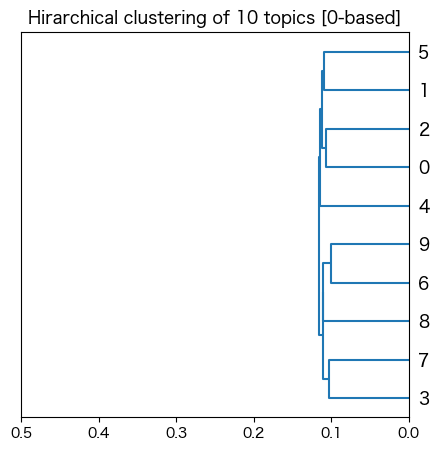

In [406]:
## D_topic_dist を使った topic の階層クラスタリング

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## 作図範囲の指定
plt.figure(figsize = (5, 5))

## 距離行列の生成
top_linkage = linkage(topic_dist, method = 'ward', metric = 'euclidean')
dendrogram(top_linkage, orientation = 'left')

## 作図
plt.xlim(0.5, 0) # 異なる分析に比較を楽にするために，x軸の大きさを固定
plt.title(f"Hirarchical clustering of {n_topics} topics [0-based]")
plt.show()

tSNE on topics

In [407]:
## tSNE を使った topic のクラスタリング

import sklearn.manifold
## reload
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn)

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い

relative = True
if relative:
    #top_perplexity_reduct_rate = 0.5 # 定義は先頭に移動
    top_perplexity_val = round(n_topics * top_perplexity_reduct_rate)
else:
    top_perplexity_val = 5 # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")

## 3D version
top_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = top_perplexity_val, n_iter = 1000)

top_perplexity_val: 5


In [408]:
## topic_dist データに適用 topic_dist のグループ化 (3D)
topic_tsne_3d = top_tSNE_3d.fit_transform(topic_dist)

In [409]:
## 必要に応じて Plotly を導入
#!pip3 install -U plotly

In [410]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)

import numpy as np
import plotly.graph_objects as go

## 変数の指定
d1, d2, d3 = topic_tsne_3d[:,0], topic_tsne_3d[:,1], topic_tsne_3d[:,2]
fig = go.Figure(data = [go.Scatter3d(x = d1, y = d2, z = d3,
                                     mode = 'markers', marker = dict(size = 7)) ])

## 3D 散布図にラベルを追加する処理は未実装
#fig.update_traces(text = [ str(x) for x in range(len(topic_dist))])
title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of {term_type}-based LDA ({n_topics} topics)"
fig.update_layout(title = dict(text = title_val),
                  autosize = False, width = 600, height = 600,)
fig.show()

In [411]:
## 構築した LDA モデルを使って文(書)を分類する
##
## .get_document_topics(..) は　minimu_probability = 0としないと
## topic の値が小さい場合に値を返さないので，

## パラメター
ntopics = n_topics # LDA の構築の最に指定した値を使う
#
check      = False
deep_check = False
#
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    if deep_check:
        print(f"i: {i}")
        print(f"doc: {doc}")
        print(f"bot: {bot}")
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check: print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

2497

In [412]:
## 確認
if verbose:
    random.sample(encoding, 2)

In [413]:
## 値がほぼ事例数なら正常
#sum([ [ y[1] for y in x ] for x in encoding ])
sum([ round(sum(map(lambda x: x[1], x)), 0) for x in encoding ])

2497.0

In [414]:
## tuple なので map(..) が必要

#df['enc'] = np.array(encoding) # This flattens arrays
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
#
df['enc']

172     [0.0047641015, 0.0047641015, 0.0047641015, 0.0...
195     [0.009091029, 0.009091029, 0.009091029, 0.9181...
735     [0.002440157, 0.002440157, 0.002440157, 0.2304...
20      [0.0024397506, 0.0024397506, 0.0024397506, 0.0...
599     [0.0047630314, 0.0047630314, 0.0047630314, 0.6...
                              ...                        
4845    [0.004762015, 0.004762015, 0.004762015, 0.0047...
31      [0.0024390519, 0.0024390519, 0.0024390519, 0.0...
452     [0.0016394199, 0.0016394199, 0.0016394199, 0.0...
2673    [0.0024391902, 0.0024391902, 0.0024391902, 0.0...
468     [0.0019608892, 0.0019608892, 0.0019608892, 0.0...
Name: enc, Length: 2497, dtype: object

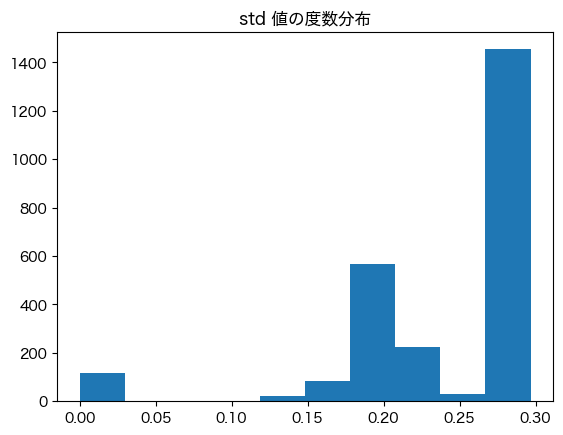

In [415]:
## エンコーディングのstd の分布を見る

#from scipy.stats import tstd
import numpy as np
from matplotlib import pyplot as plt
## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans"

std_dist = [ np.std(x) for x in df['enc'] ]

plt.hist(std_dist)
plt.title(f"std 値の度数分布")
plt.show()

## 0 周辺に事例があるなら，エンコーディング効率が悪い

In [416]:
## 一様分布の事例を除外

import numpy as np

check = False
enc = df['enc']

print(f"{len(df)} instances before filtering")

max_std = max([ np.std(x) for x in enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in enc])))[-1]
print(f"std 2nd min: {second_min_std}")

2497 instances before filtering
std 1st min: 0.0
std 2nd min: 0.2967028319835663


In [417]:
## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
import numpy as np

std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]

## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
classified = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ classified ]
#
print(f"filtering leaves {len(df_filtered)} instances ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.07417570799589157
filtering leaves 2382 instances (115 instances removed)


In [418]:
## 弱いサンプリング

secondary_sampling = False
if secondary_sampling:
    df = df.sample(round(len(df) * 0.5))
len(df)

2497

In [419]:
df['domain_id'].value_counts().sort_index()

## 0: 医療用語
## 1: 医療縮約表現
## 2: 調理用語
## 3: 経済用語
## 4: 法律用語
## 5: 出版用語
## 6: その他

domain_id
0    500
2    500
3    497
4    500
5    500
Name: count, dtype: int64

tSNE on documents

In [420]:
## tSNE を使った documents のクラスタリング

import sklearn.manifold
## reload
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn)

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い
relative = True
if relative:
    doc_perplexity_val = round(len(df) * doc_perplexity_reduct_rate)
else:
    doc_perplexity_val = 15 # 大き過ぎると良くない
print(f"doc_perplexity_val: {doc_perplexity_val}")

## 3D version
doc_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = doc_perplexity_val, n_iter = 1000)
## データに適用
E = np.array(list(df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(E)

doc_perplexity_val: 250


In [421]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)

import plotly.graph_objects as go
import numpy as np

## 変数の特定
d1, d2, d3 = doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2]
cmap = list(map(lambda i: colormap[i], df['domain_id'])) # colormap は最初に定義してある
fig = go.Figure(data = [ go.Scatter3d(x = d1, y = d2, z = d3,
                                     mode = 'markers', marker = dict(size = 5, color = cmap)
                                    ) ] )

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"tSNE (ppl: {doc_perplexity_val}) 3D clustering of {len(doc_tSNE_3d)} docs encoded by {term_type}-based LDA ({n_topics} topics)"
fig.update_layout(title = dict(text = title_val),
    autosize = False, width = 700, height = 700)
fig.show()

## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: 赤 Pink
## 調理用語:    オレンジ Orange
## 経済用語:    緑 Green
## 法律用語:    明るい緑 Pale Turquoise
## 出版用語:    小麦色 wheat
## その他:      灰色 gray

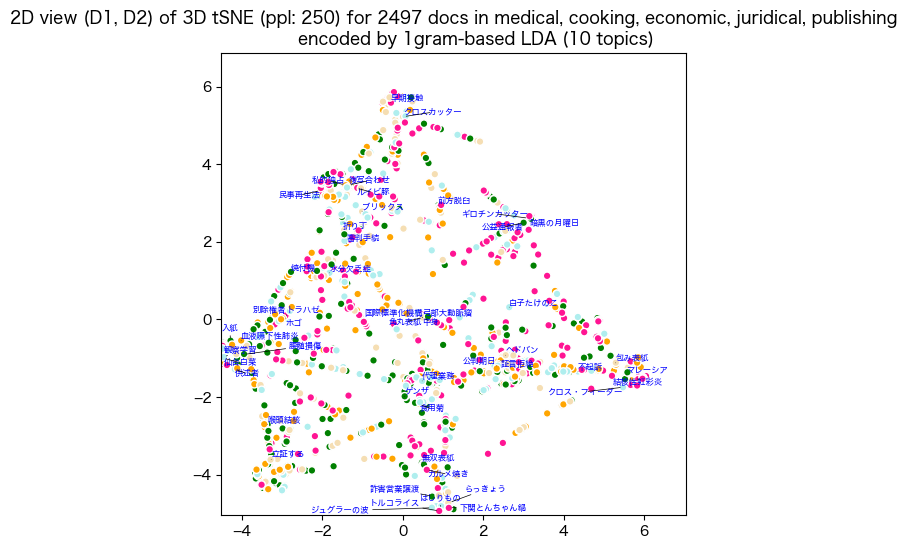

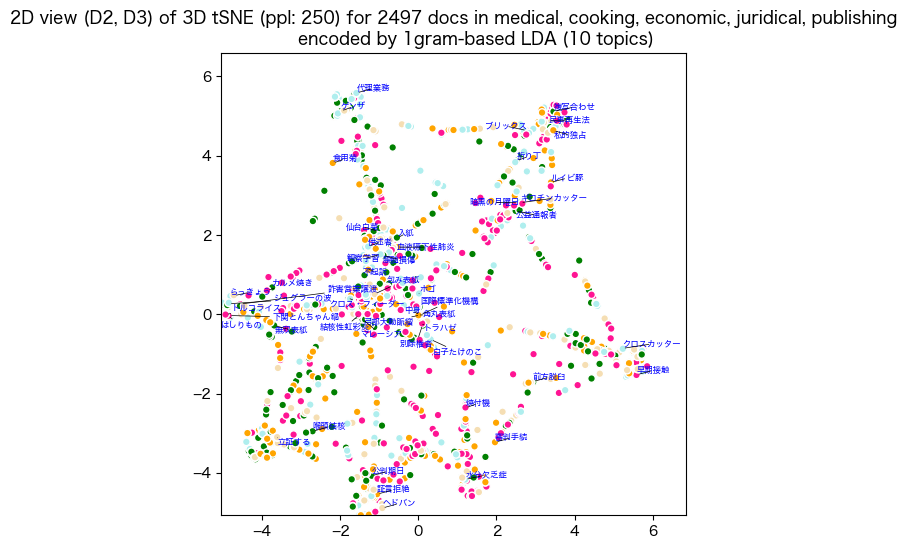

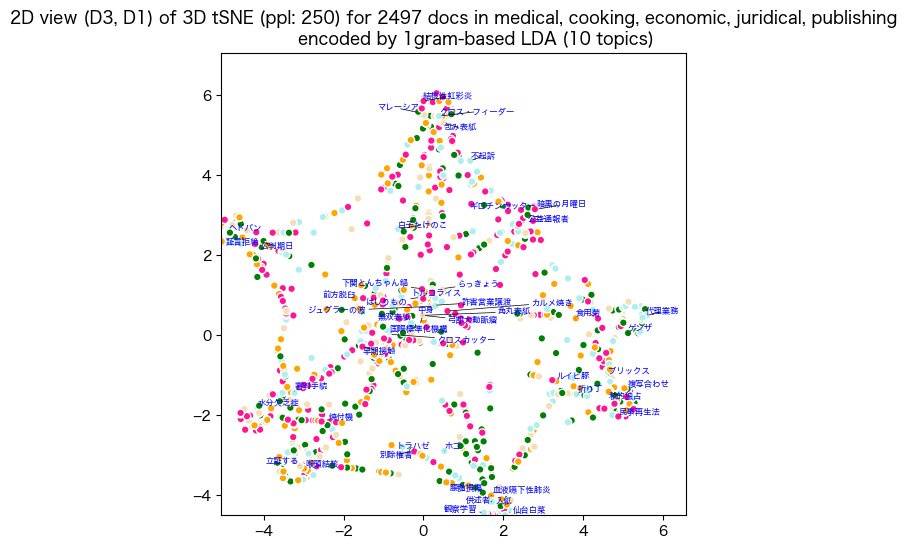

In [422]:
%%capture --no-display

## tSNE の結果の可視化

import matplotlib.pyplot as plt
from adjustText import adjust_text

## 文字を表示する事例のサンプリング
relative = True
lab_sampling_rate = 0.02 # サンプリング率の指定
if relative:
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定
print(f"lab_sample_n: {lab_sample_n}")

## labels の生成
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]

##
for i in range(3):
    roll = np.roll([0,1,2], -i)
    asp1, asp2 = roll[0], roll[1]
    X, Y = doc_tSNE_3d[:, asp1], doc_tSNE_3d[:, asp2]
    
    ## 
    plt.figure(figsize = (6, 6))
    plt.xlim(X.min(), X.max() + 1)
    plt.ylim(Y.min(), Y.max() + 1)

    ## 分野ごとの色分け
    #scatter = plt.scatter(X, Y, s = 30, c = 'r', edgecolors = 'w')
    cmap = list(map(lambda i: colormap[i], df['domain_id'])) # colormap は最初に定義してある
    scatter = plt.scatter(X, Y, s = 30, c = cmap, edgecolors = 'w')
    
    ##
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 6, color = 'blue'))

    ## label に repel を追加: adjustText package の導入が必要
    get_Float_object_is_not_subsriptable_Error = False
    if get_Float_object_is_not_subsriptable_Error:
        pass
    else:
        adjust_text(texts,
                    expand_points = (1, 1), expand_text = (1, 1),
                    force_points = 0.2,
                    force_text = 0.2,
                    arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    plt.title(f"2D view (D{asp1+1}, D{asp2+1}) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs in {', '.join(selected_domains.keys())}\n\
        encoded by {term_type}-based LDA ({n_topics} topics)")
    plt.show()

## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: 赤 Pink
## 調理用語:    オレンジ Orange
## 経済用語:    緑 Green
## 法律用語:    明るい緑 Pale Turquoise
## 出版用語:    小麦色 wheat
## その他:      灰色 gray

DBSCAN でクラスタリング

In [447]:
## DBSCAN でクラスタリング
from sklearn.cluster import DBSCAN

## eps は事例ごとに調節が必要
eps_val = 0.7; min_samples_val = 2
D_clustered = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(doc_tSNE_3d)

## cluster id の取得
cluster_ids = D_clustered.labels_
np.unique(cluster_ids)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23])

In [448]:
## 必要に応じて Seaborn を道入
#!pip install -U seaborn

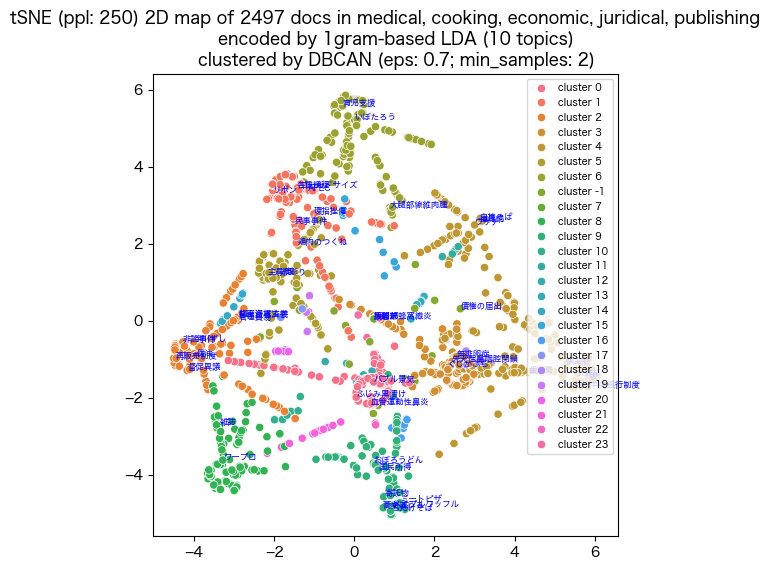

In [449]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (6, 6))
d1, d2 = doc_tSNE_3d[:,0], doc_tSNE_3d[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in cluster_ids ])

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.2 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(df_sampled))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]

texts = [ ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 6, color = 'blue'))

## 題名を指定
plt.title(f"tSNE (ppl: {doc_perplexity_val}) 2D map of {len(df)} docs in {', '.join(selected_domains.keys())}\n\
    encoded by {term_type}-based LDA ({n_topics} topics)\n\
    clustered by DBCAN (eps: {eps_val}; min_samples: {min_samples_val})")
#
plt.show()

## DBSCAN で局所化の効果は確認できる
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

階層クラスタリングのための再サンプリング

In [450]:
## 階層クラスタリングのための事例サンプリング
doc_sampling_rate = 0.1 # 変更可能: 大きくし過ぎると図が見にくい
df_size = len(df_filtered)
if df_size > 600:
    df_sampled = df_filtered.sample(round(df_size * doc_sampling_rate))
else:
    df_sampled = df_filtered
##
print(f"{len(df_sampled)} rows are sampled (preservation rate: {len(df_sampled)/len(df_filtered):0.3f})")

238 rows are sampled (preservation rate: 0.100)


In [451]:
## domain 事例数の確認
df_sampled['domain_id'].value_counts().sort_index()

domain_id
0    58
2    61
3    39
4    39
5    41
Name: count, dtype: int64

階層クラスタリング

In [452]:
## Plotly が必要な場合に実行
#!pip install -U plotly

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_9182/3630053865.py:32: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



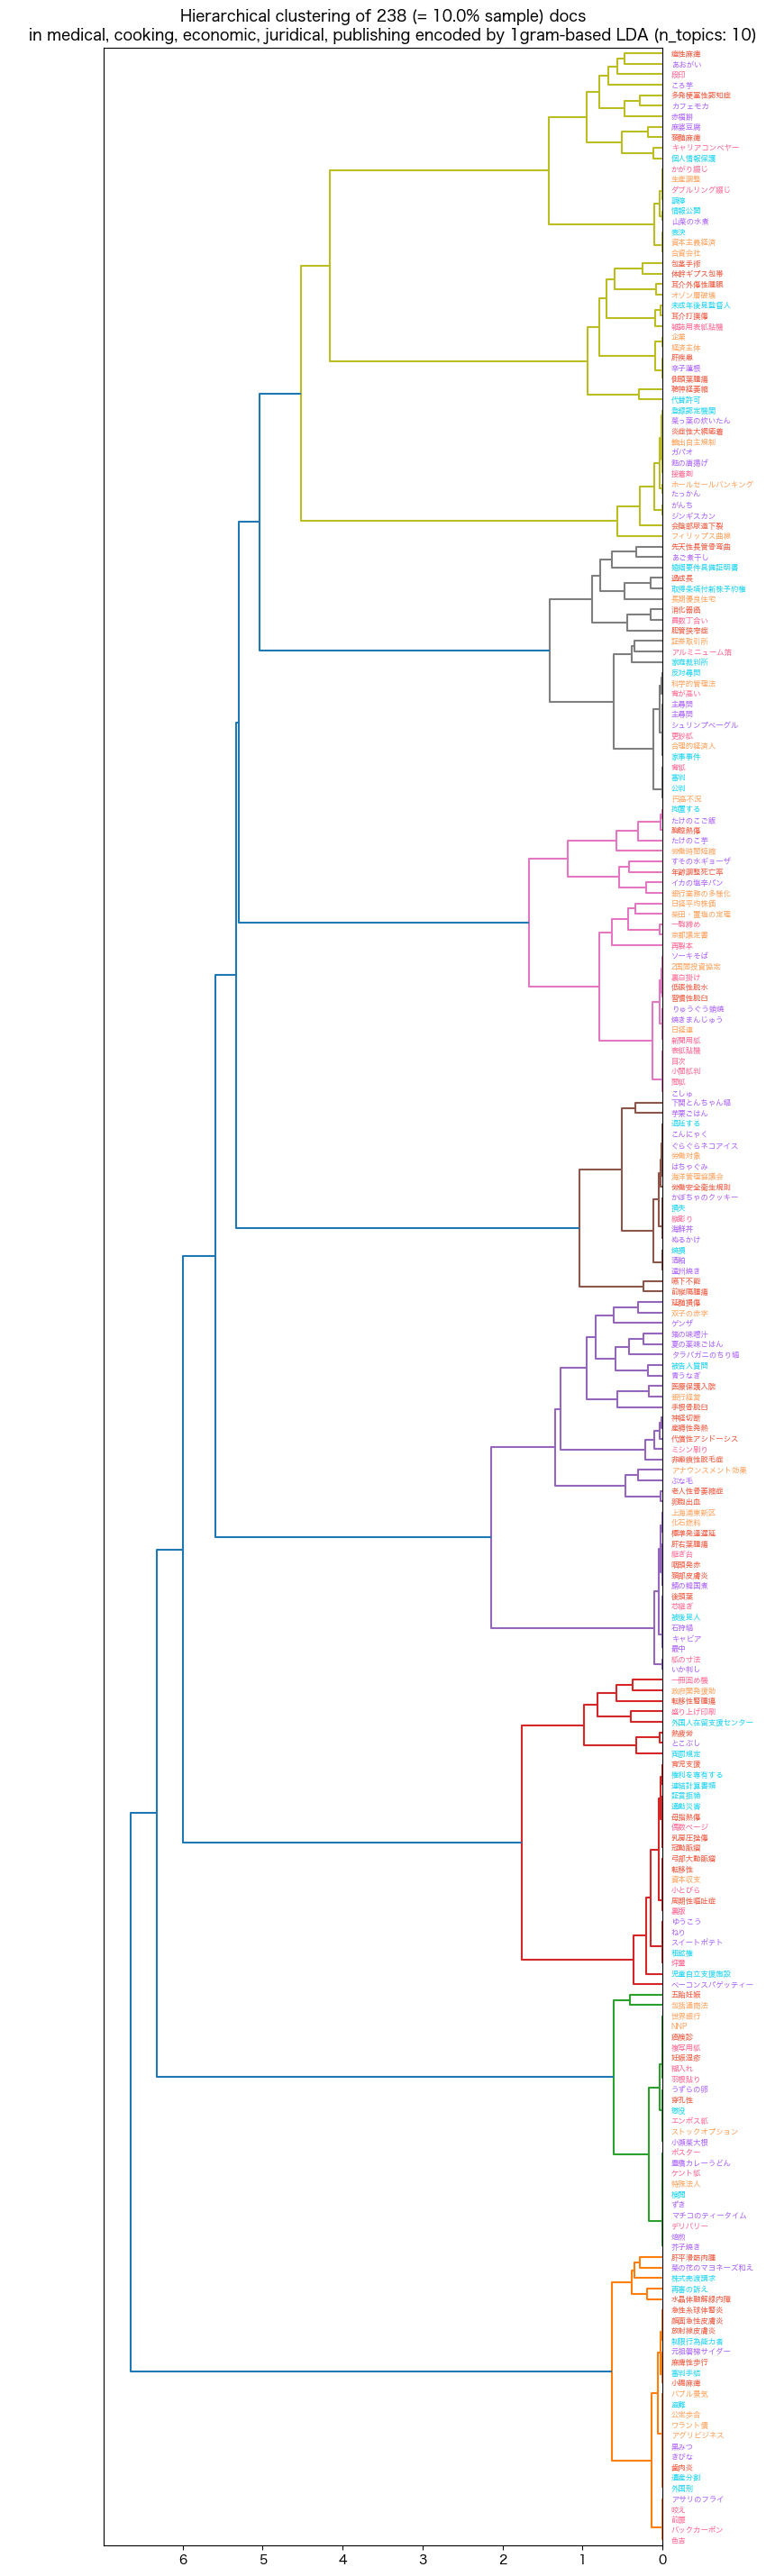

In [453]:
## doc 階層クラスタリングの実行

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino sans" # 日本語表示のための設定
import plotly

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_linkage = linkage(list(df_sampled['enc']), method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (8, round(10 * len(df_sampled) * 0.015))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(df_sampled[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 6)

## 描画
plt.title(f"Hierarchical clustering of {len(df_sampled)} (= {100 * doc_sampling_rate}% sample) docs\n\
    in {', '.join(selected_domains.keys())} encoded by {term_type}-based LDA (n_topics: {n_topics})")

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    row = df_sampled.loc[df_sampled[doc_type] == word]
    try:
        domain_id = int(row['domain_id'])
    except TypeError:
        pass
    ticker.set_color(plotly.colors.qualitative.Plotly[domain_id + 1]) # id の基数調整
#
plt.show()

## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: 赤 Pink
## 調理用語:    オレンジ Orange
## 経済用語:    緑 Green
## 法律用語:    明るい緑 Pale Turquoise
## 出版用語:    小麦色 wheat
## その他:      灰色 gray